In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt

In [ ]:
IMAGES_DATA=[]
for label,folder in enumerate(os.listdir('/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/capsnet-keras/Original')):
  for file in os.listdir(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/capsnet-keras/Original/{folder}'):
    img=cv2.imread(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/capsnet-keras/Original/{folder}/{file}')
    img=cv2.resize(img,(128,128))
    IMAGES_DATA.append((img/255.0,label))
IMAGES_DATA=np.array(IMAGES_DATA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [ ]:
mask_DATA=[]
for label,mask in enumerate(os.listdir('/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Segmented')):
  for mask_file in os.listdir(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Segmented/{mask}'):
    img=cv2.imread(f'/content/drive/MyDrive/DataSets/Acute Leukemia Cancer Data/Segmented/{mask}/{mask_file}')
    img=cv2.resize(img,(128,128))
    mask_DATA.append((np.round(img/255.0),label))
mask_DATA=np.array(mask_DATA)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [ ]:
DATA=np.array([(image,mask,label) for image,mask,label in zip(IMAGES_DATA[:,0],mask_DATA[:,0],IMAGES_DATA[:,1])])
DATA=shuffle(DATA)
IMAGES=np.array([ i for i in DATA[:,0]]).reshape(3256,128,128,3)
MASKS=np.array([ i for i in DATA[:,1]]).reshape(3256,128,128,3)
LABEL=DATA[:,2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


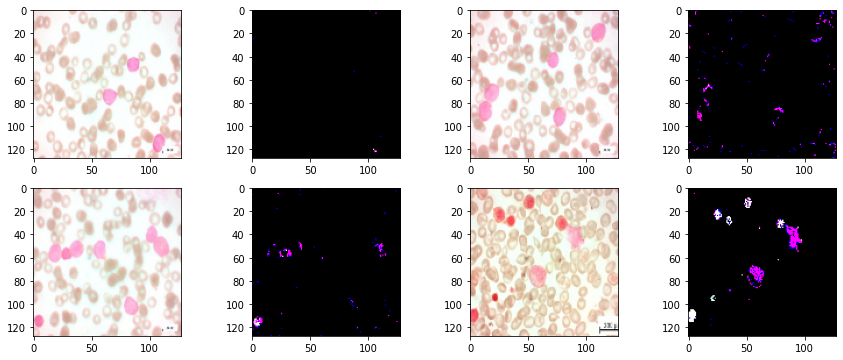

(<matplotlib.image.AxesImage at 0x7f50ee6aa850>, None)

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
plt.subplot(2,4,1),plt.imshow(IMAGES[0]),plt.subplot(2,4,2),plt.imshow(MASKS[0]),plt.subplot(2,4,3)
plt.imshow(IMAGES[1500]),plt.subplot(2,4,4),plt.imshow(MASKS[1500]),plt.subplot(2,4,5),plt.imshow(IMAGES[330])
plt.subplot(2,4,6),plt.imshow(MASKS[330]),plt.subplot(2,4,7),plt.imshow(IMAGES[2310]),plt.subplot(2,4,8)
plt.imshow(MASKS[2310]),plt.show()

In [ ]:
x_train,x_test,x_label,y_label=IMAGES[:2600],IMAGES[2600:],LABEL[:2600],LABEL[2600:]
y_train,y_test=np.round(MASKS[:2600]),np.round(MASKS[2600:])
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((2600, 128, 128, 3),
 (656, 128, 128, 3),
 (2600, 128, 128, 3),
 (656, 128, 128, 3))

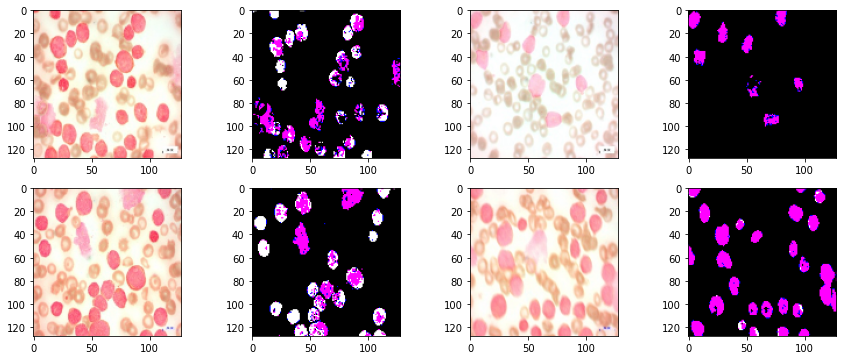

(<matplotlib.image.AxesImage at 0x7f50ec7417d0>, None)

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
plt.subplot(2,4,1),plt.imshow(x_train[113]),plt.subplot(2,4,2),plt.imshow(y_train[113]),plt.subplot(2,4,3)
plt.imshow(x_train[17]),plt.subplot(2,4,4),plt.imshow(y_train[17]),plt.subplot(2,4,5),plt.imshow(x_train[268])
plt.subplot(2,4,6),plt.imshow(y_train[268]),plt.subplot(2,4,7),plt.imshow(x_train[130]),plt.subplot(2,4,8)
plt.imshow(y_train[130]),plt.show()

## UNet Algorithm 

In [ ]:
from keras import layers

def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

In [ ]:
inputs = layers.Input(shape=(128,128,3))

f1, p1 = downsample_block(inputs, 8)
f2, p2 = downsample_block(p1, 16)
f3, p3 = downsample_block(p2, 32)
f4, p4 = downsample_block(p3, 64)

bottleneck = double_conv_block(p4, 24)

u6 = upsample_block(bottleneck, f4, 64)
u7 = upsample_block(u6, f3, 32)
u8 = upsample_block(u7, f2, 16)
u9 = upsample_block(u8, f1, 8)

outputs = layers.Conv2D(3, 1, padding="same", activation = "sigmoid")(u9)

unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
# plot_model(unet_model,rankdir='LR',to_file='model.png')

In [ ]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=dice_coef)
model_history = unet_model.fit(x_train,y_train,epochs=100)

Epoch 1/100
82/82 [==============================] - 18s 62ms/step - loss: 0.7253
Epoch 2/100
82/82 [==============================] - 4s 53ms/step - loss: 0.4625
Epoch 3/100
82/82 [==============================] - 4s 53ms/step - loss: 0.4188
Epoch 4/100
82/82 [==============================] - 4s 53ms/step - loss: 0.3805
Epoch 5/100
82/82 [==============================] - 4s 54ms/step - loss: 0.3541
Epoch 6/100
82/82 [==============================] - 5s 57ms/step - loss: 0.3424
Epoch 7/100
82/82 [==============================] - 4s 53ms/step - loss: 0.3359
Epoch 8/100
82/82 [==============================] - 4s 53ms/step - loss: 0.3301
Epoch 9/100
82/82 [==============================] - 4s 54ms/step - loss: 0.3251
Epoch 10/100
82/82 [==============================] - 4s 54ms/step - loss: 0.3204
Epoch 11/100
82/82 [==============================] - 4s 53ms/step - loss: 0.3176
Epoch 12/100
82/82 [==============================] - 4s 54ms/step - loss: 0.3140
Epoch 13/100
82/82 [====

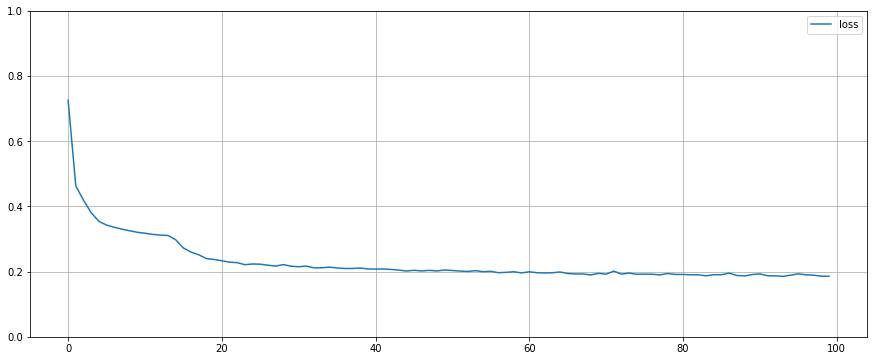

In [ ]:
pd.DataFrame(model_history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
unet_model.evaluate(x_test,y_test)

21/21 [==============================] - 1s 36ms/step - loss: 0.1758


0.17577169835567474

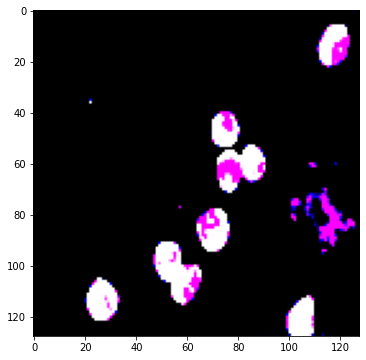

In [ ]:
preds=unet_model.predict(x_test)
plt.imshow(preds[0])

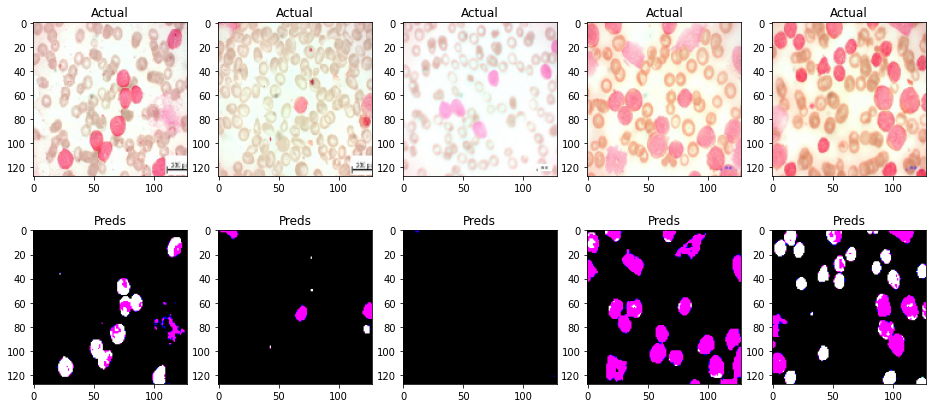

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((x_test[i]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(np.round(preds[i]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

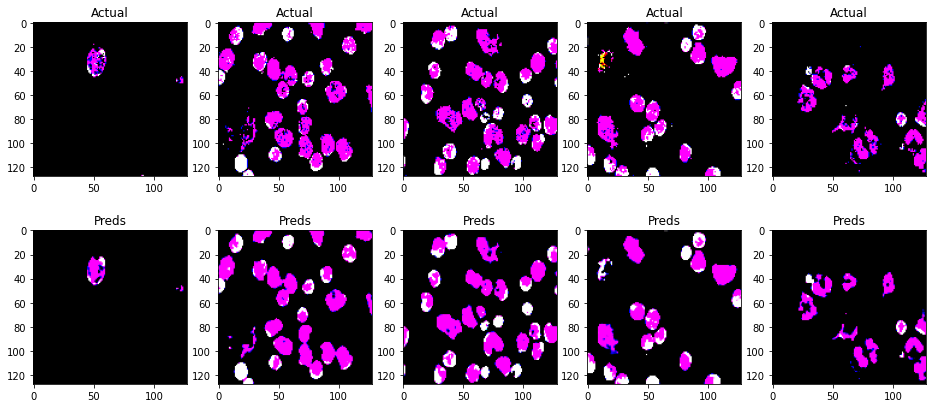

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+150]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((preds[i+150]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

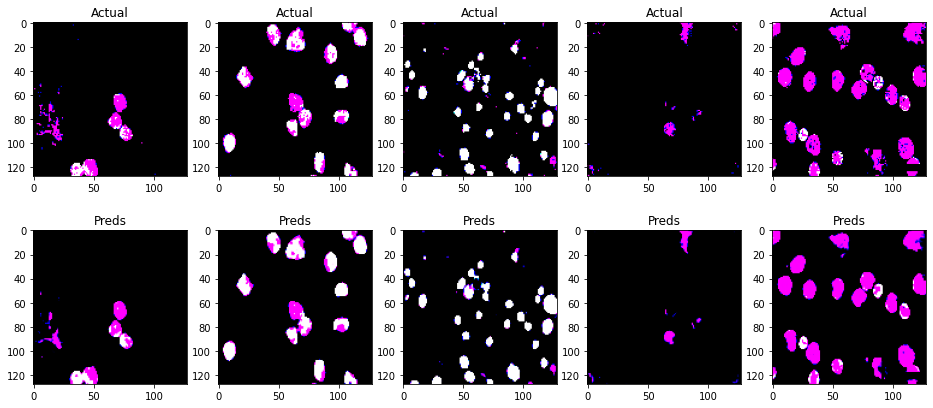

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+100]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((preds[i+100]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

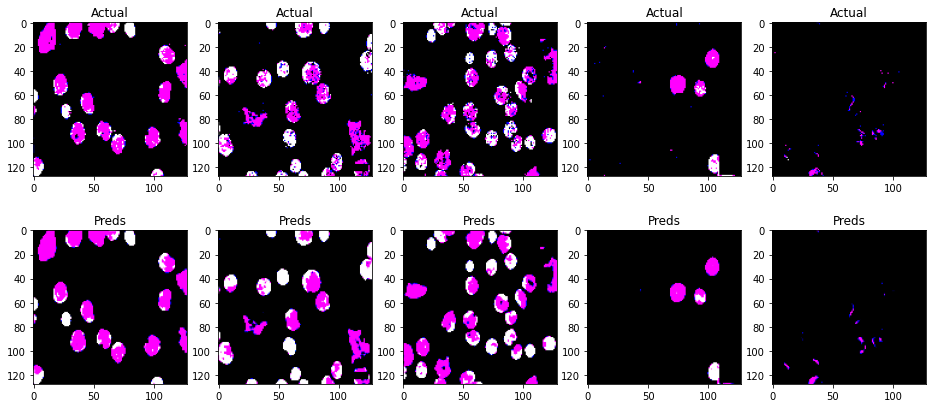

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+450]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((preds[i+450]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


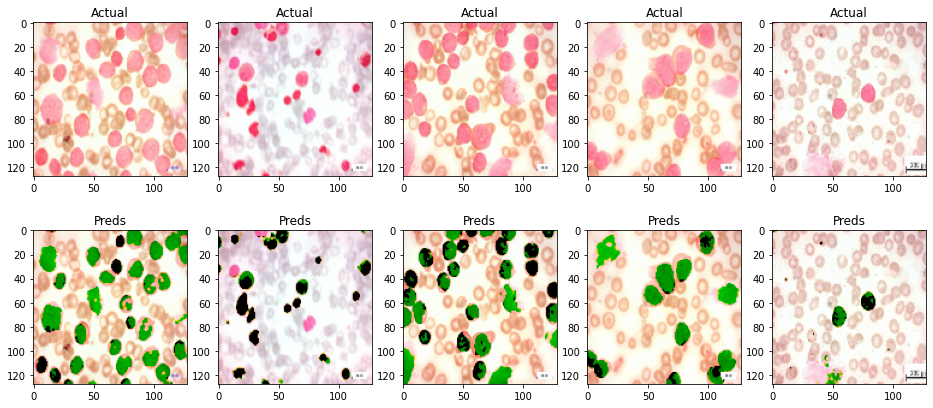

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((x_test[i+460]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(x_test[i+460]-(preds[i+460]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


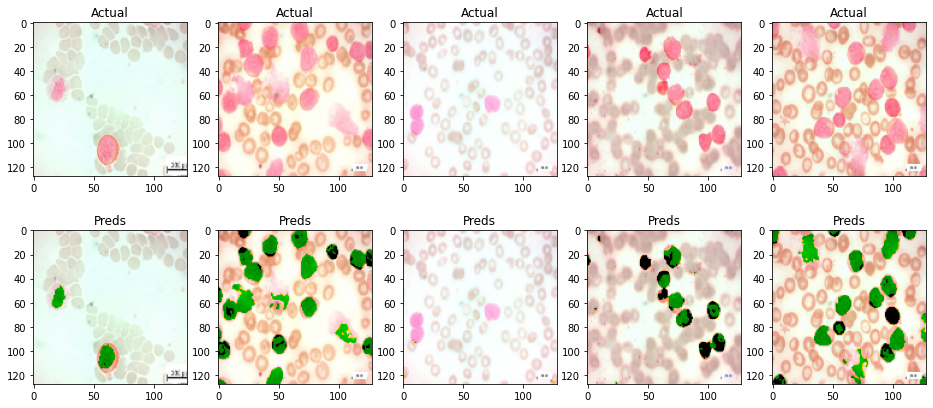

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((x_test[i+40]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(x_test[i+40]-np.round(preds[i+40]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


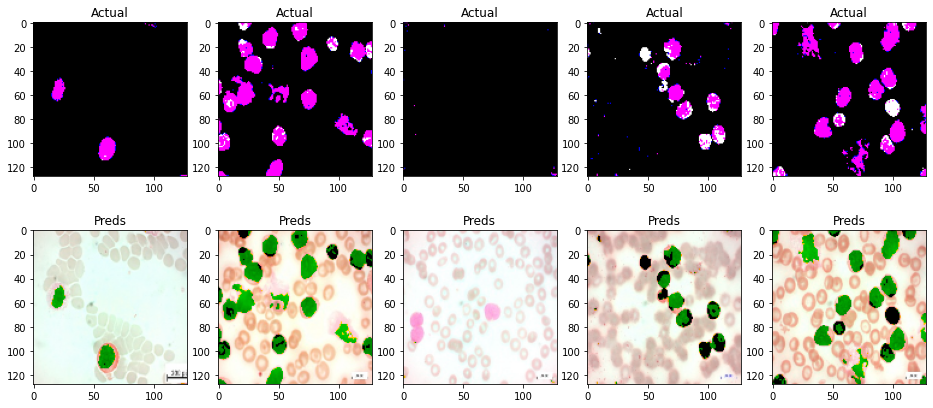

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+40]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(x_test[i+40]-np.round(preds[i+40]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

## Variational Modified UNet With Attension Mechansim

In [ ]:
from tensorflow.keras import layers

def double_conv_block(x, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   x=keras.layers.BatchNormalization()(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = double_conv_block(x, n_filters)
   return x

def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio,activation='relu')(x)
    x = keras.layers.Dense(ch,activation='sigmoid')(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

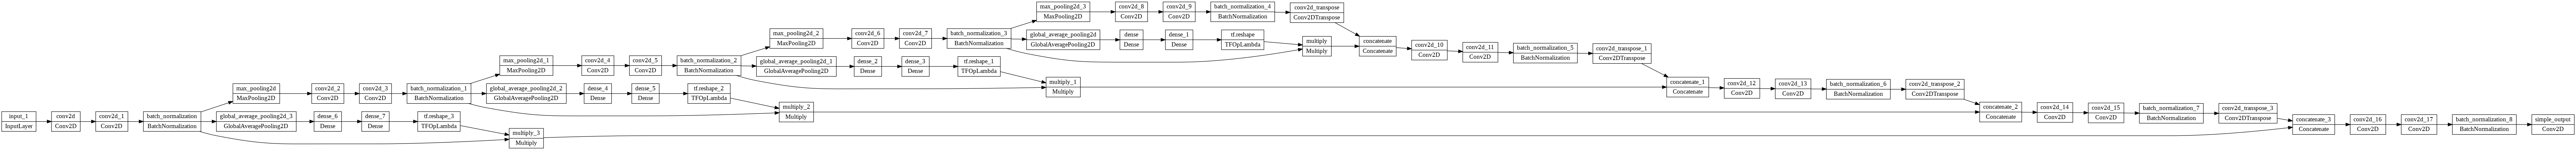

In [ ]:
inputs = layers.Input(shape=(128,128,3))

f1, p1 = downsample_block(inputs, 8)
f2, p2 = downsample_block(p1, 16)
f3, p3 = downsample_block(p2, 32)
f4, p4 = downsample_block(p3, 64)

bottleneck = double_conv_block(p4, 24)

f4_seblock=SE_BLOCK(f4,64)
u6 = upsample_block(bottleneck, f4_seblock, 64)
f3_seblock=SE_BLOCK(f3,32)
u7 = upsample_block(u6, f3_seblock, 32)
f2_seblock=SE_BLOCK(f2,16)
u8 = upsample_block(u7, f2_seblock, 16)
f1_seblock=SE_BLOCK(f1,8)
u9 = upsample_block(u8, f1_seblock, 8)


outputs1 = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='simple_output')(u9)
 
modified_unet_model = tf.keras.Model(inputs, [outputs1], name="U-Net")
plot_model(modified_unet_model,rankdir='LR',to_file='model2.png')

In [ ]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice
from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

modified_unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                            loss='binary_crossentropy',metrics=[dice_coef,keras.metrics.Recall()])
model_history = modified_unet_model.fit(x_train,y_train,epochs=800)

Epoch 1/800
82/82 [==============================] - 23s 67ms/step - loss: 0.5712 - dice_coef: 0.1987 - recall: 0.8766
Epoch 2/800
82/82 [==============================] - 5s 62ms/step - loss: 0.3956 - dice_coef: 0.2736 - recall: 0.9234
Epoch 3/800
82/82 [==============================] - 5s 60ms/step - loss: 0.2751 - dice_coef: 0.3443 - recall: 0.9023
Epoch 4/800
82/82 [==============================] - 5s 59ms/step - loss: 0.1839 - dice_coef: 0.4289 - recall: 0.8934
Epoch 5/800
82/82 [==============================] - 5s 59ms/step - loss: 0.1262 - dice_coef: 0.5213 - recall: 0.8880
Epoch 6/800
82/82 [==============================] - 5s 59ms/step - loss: 0.0930 - dice_coef: 0.5993 - recall: 0.8838
Epoch 7/800
82/82 [==============================] - 5s 59ms/step - loss: 0.0732 - dice_coef: 0.6614 - recall: 0.8870
Epoch 8/800
82/82 [==============================] - 5s 59ms/step - loss: 0.0613 - dice_coef: 0.7051 - recall: 0.8874
Epoch 9/800
82/82 [==============================] - 5s

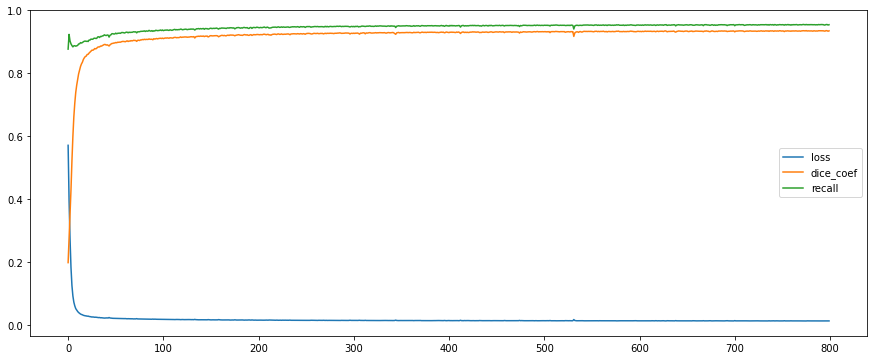

In [ ]:
pd.DataFrame(model_history.history).plot()

In [ ]:
modified_unet_model.evaluate(x_test,y_test)

21/21 [==============================] - 2s 33ms/step - loss: 0.0210 - dice_coef: 0.9213 - recall: 0.9294


[0.02103450894355774, 0.9213062524795532, 0.9294208884239197]

## Sagmentation Visualization

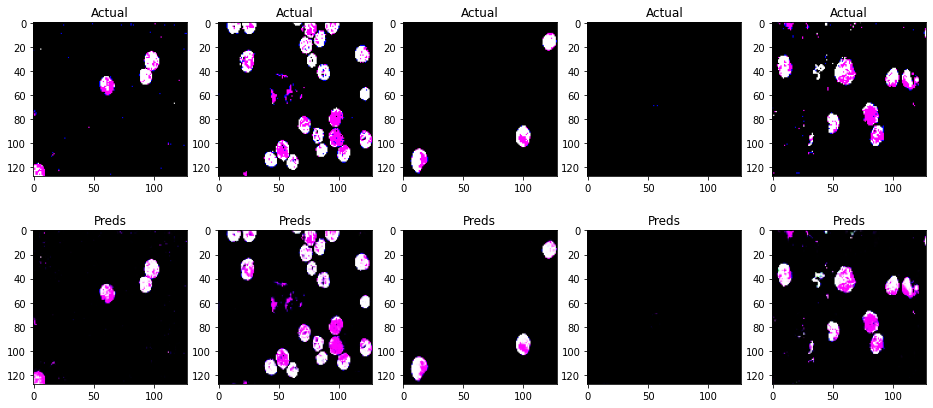

In [ ]:
modeified_preds=modified_unet_model.predict(x_test)
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(modeified_preds[i])
  plt.title('Preds')
plt.show()

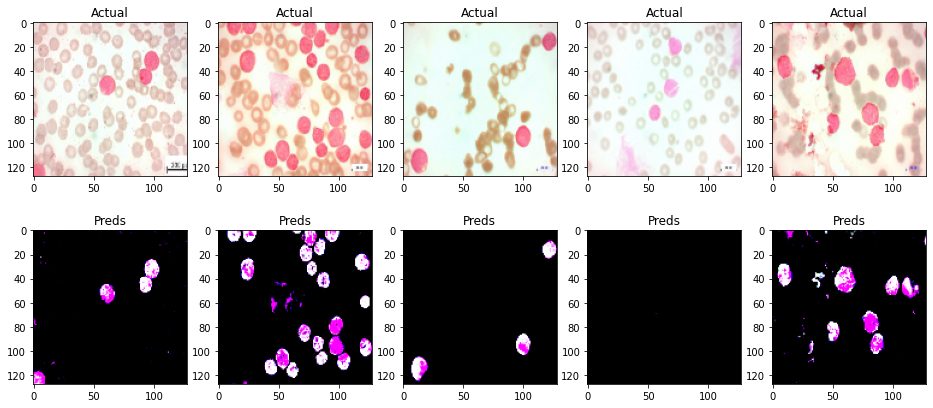

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((x_test[i]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(modeified_preds[i])
  plt.title('Preds')
plt.show()

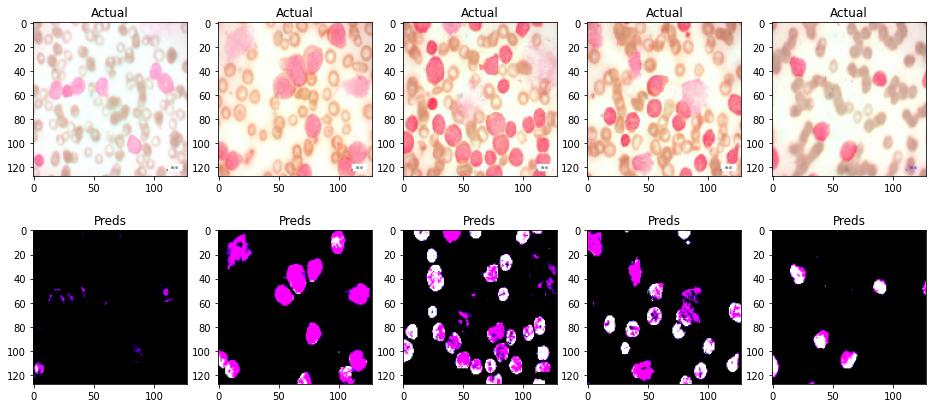

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((x_test[i+120]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i+120]))
  plt.title('Preds')
plt.show()

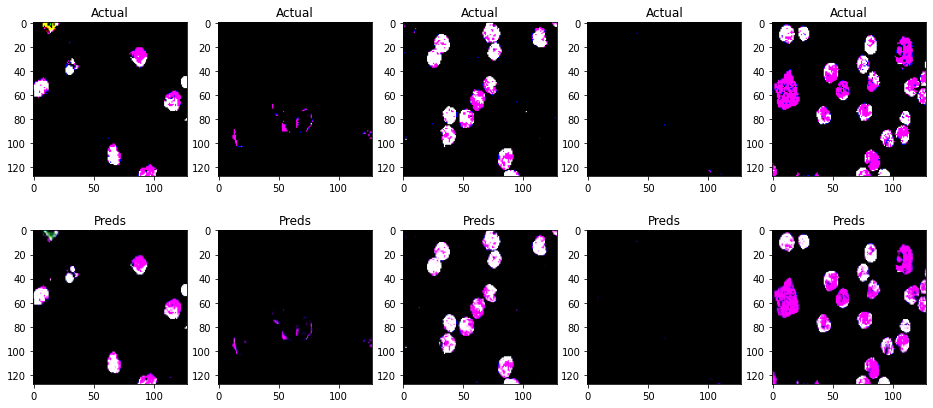

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+110]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i+110]))
  plt.title('Preds')
plt.show()

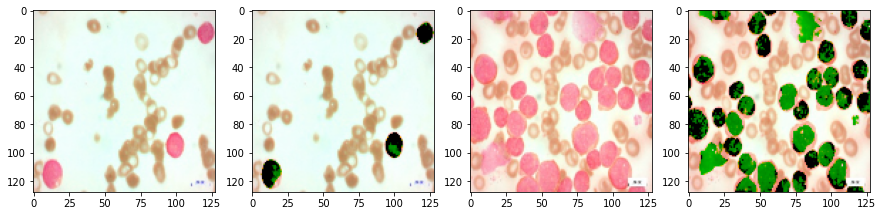

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
plt.subplot(1,4,1)
plt.imshow(x_test[2])
plt.subplot(1,4,2)
plt.imshow(x_test[2]-(modeified_preds[2]))
plt.subplot(1,4,3)
plt.imshow(x_test[10])
plt.subplot(1,4,4)
plt.imshow(x_test[10]-(modeified_preds[10]))
plt.show()

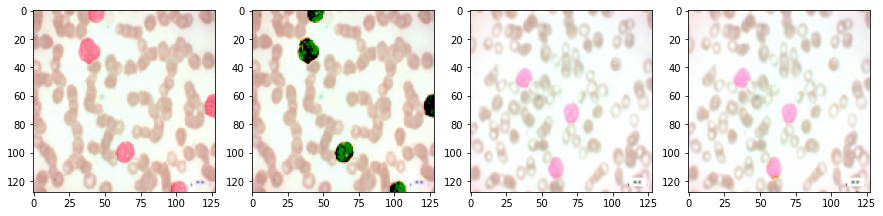

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
plt.subplot(1,4,1)
plt.imshow(x_test[431])
plt.subplot(1,4,2)
plt.imshow(x_test[431]-(modeified_preds[431]))
plt.subplot(1,4,3)
plt.imshow(x_test[25])
plt.subplot(1,4,4)
plt.imshow(x_test[25]-(modeified_preds[25]))
plt.show()

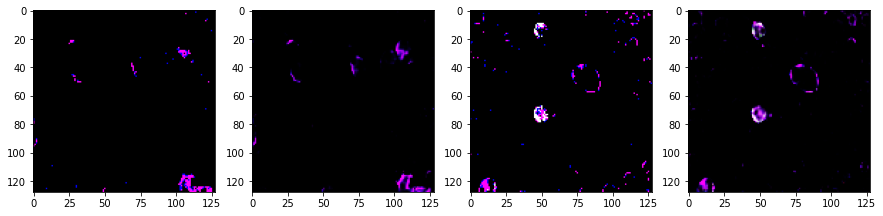

In [ ]:
plt.rcParams['figure.figsize']=(15,5)
plt.subplot(1,4,1)
plt.imshow(y_test[631])
plt.subplot(1,4,2)
plt.imshow((modeified_preds[631]))
plt.subplot(1,4,3)
plt.imshow(y_test[51])
plt.subplot(1,4,4)
plt.imshow((modeified_preds[51]))
plt.show()

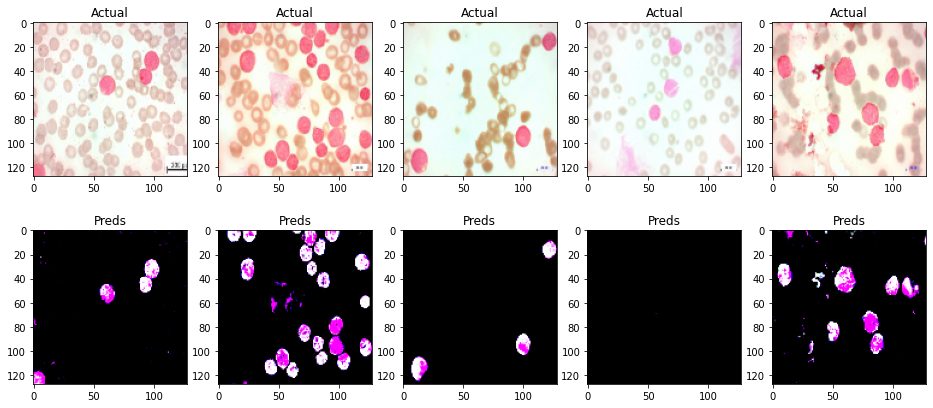

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((x_test[i]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

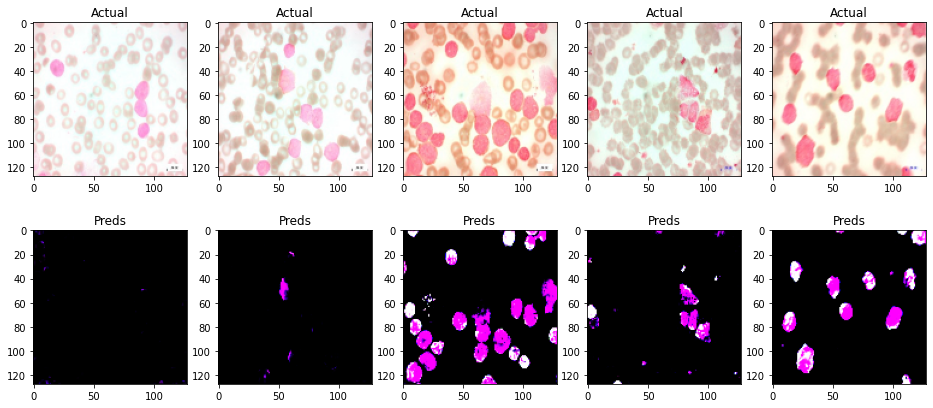

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((x_test[i+160]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i+160]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

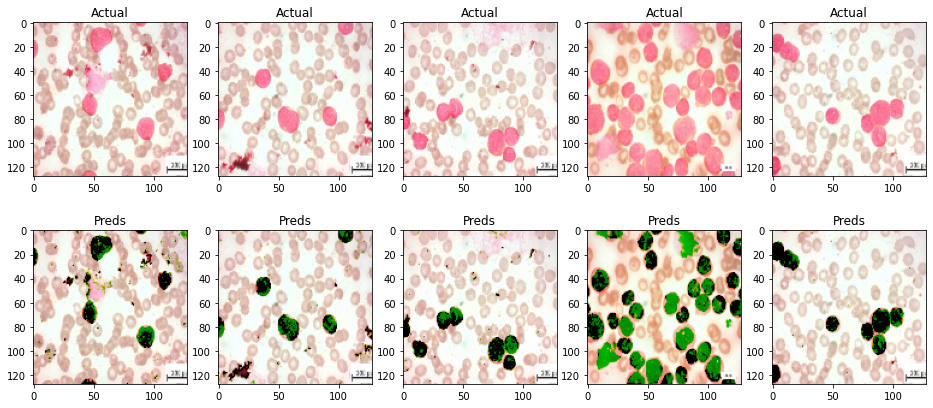

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((x_test[i+7]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(x_test[i+7]-(modeified_preds[i+7]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

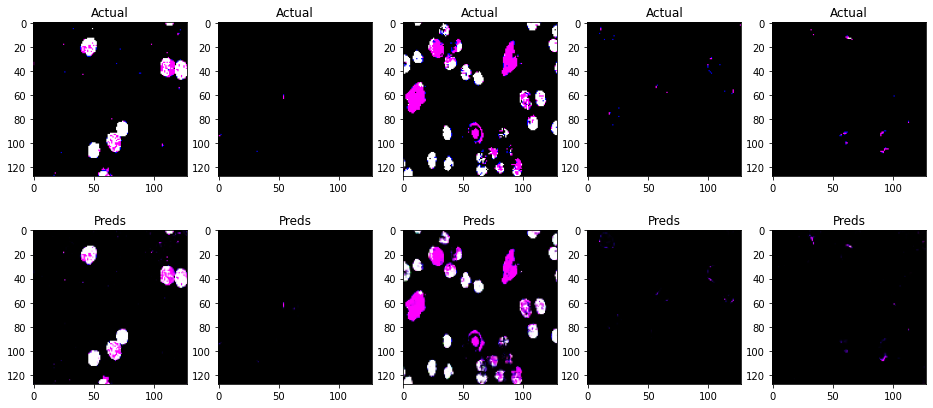

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+222]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i+222]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

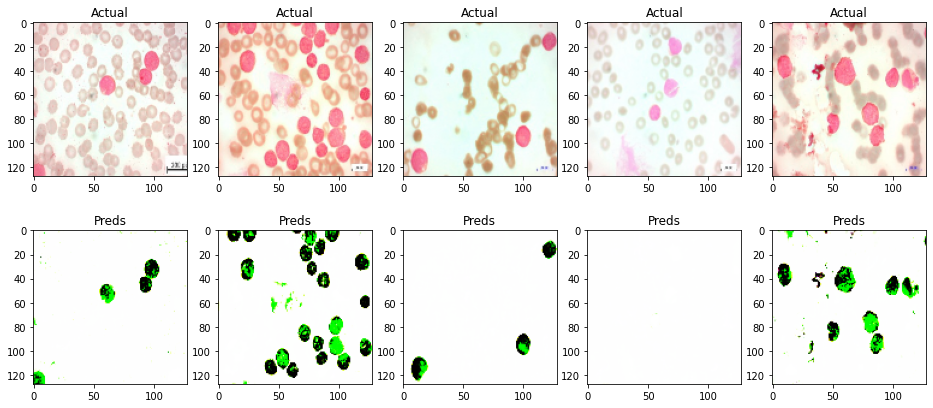

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((x_test[i]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(1-(modeified_preds[i]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

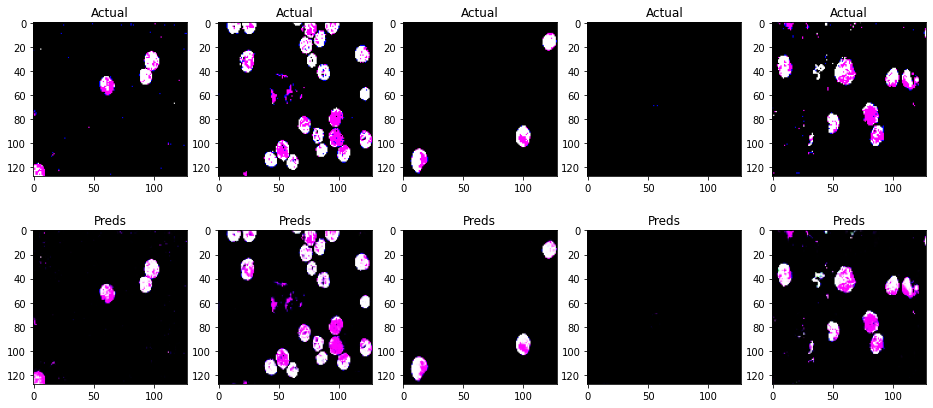

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

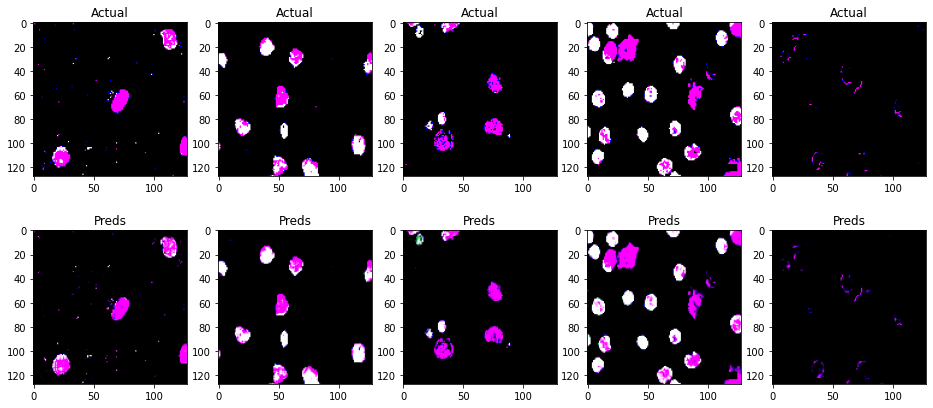

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+461]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i+461]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import os

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))

In [ ]:
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_segmentation_masks
import torch
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import cv2


torch.Size([3, 128, 128])
[tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0

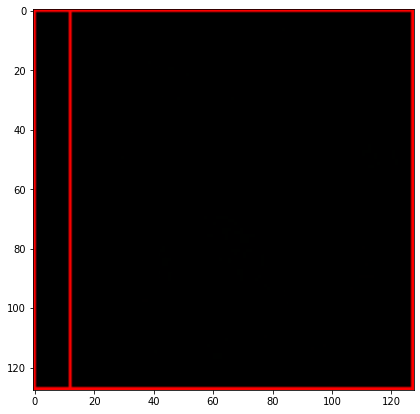

In [ ]:
def rec_box(test_path, mask_path , model, image_size=128 ) :
    x_pred = modified_unet_model.predict(test_path.reshape(1,128,128,3))
    x_pred=x_pred.reshape((128,128,3))
    mask = x_pred > 0.5
    mask = np.array(mask , dtype = bool)
    mask = torch.from_numpy(mask).float()
    mask = torch.permute( mask , (2,0,1))

    obj_ids = torch.unique(mask)
    # first id is the background, so remove it.
    obj_ids = obj_ids[1:]
    # split the color-encoded mask into a set of boolean masks.
    # Note that this snippet would work as well if the masks were float values instead of ints.
    masks = mask == obj_ids[:, None, None]
    masks=masks.reshape((3,128,128))
    drawn_masks = []
    img= torch.permute( torch.tensor(test_path) , (2,0,1))
    print(masks.shape)
    for mask in masks:
        drawn_masks.append(draw_segmentation_masks(img.to(torch.uint8), mask, alpha=0.8, colors="blue"))
    print(drawn_masks)
    boxes = masks_to_boxes(masks)
    drawn_boxes = draw_bounding_boxes(img.to(torch.uint8), boxes, colors="red" )
    show(drawn_boxes)
    return drawn_boxes


box=rec_box(x_train[2] , y_train[2] , modified_unet_model, image_size= 128)


In [ ]:
ASSETS_DIRECTORY = "assets"

plt.rcParams["savefig.bbox"] = "tight"


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

mask= modified_unet_model.predict(x_train[0].reshape(1,128,128,3)).reshape((128,128,3))
mask = torch.permute( torch.tensor(mask) , (2,0,1))

# We get the unique colors, as these would be the object ids.
obj_ids = torch.unique(mask)

# first id is the background, so remove it.
obj_ids = obj_ids[1:]
 
# split the color-encoded mask into a set of boolean masks.
# Note that this snippet would work as well if the masks were float values instead of ints.
masks=mask>0.3
from torchvision.utils import draw_segmentation_masks
img = torch.permute(torch.tensor(x_train[0]).to(torch.uint8) , (2,0,1))

drawn_masks = []
for mask in masks:
    drawn_masks.append(draw_segmentation_masks(img, mask, alpha=0.8, colors="blue"))

show(drawn_masks)


from torchvision.ops import masks_to_boxes
print(masks.shape)
boxes = masks_to_boxes(masks)
print(boxes.size())
print(boxes)


from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img, boxes, colors="red")
show(drawn_boxes)

## Experiment

In [ ]:
def double_conv_block(inp, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(inp)
   x=keras.layers.BatchNormalization()(x)
   u=keras.layers.concatenate([inp,x])
   v = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(u)
   v=keras.layers.BatchNormalization()(v)
   x=keras.layers.concatenate([u,v,inp])
   return x
def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio,activation='relu')(x)
    x = keras.layers.Dense(ch,activation='sigmoid')(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

In [ ]:
inputs = layers.Input(shape=(128,128,3))
inp_seblock=SE_BLOCK(inputs,3)
f1, p1 = downsample_block(inp_seblock, 3)
p1_seblock=SE_BLOCK(p1,12)
f2, p2 = downsample_block(p1_seblock, 3)
p2_seblock=SE_BLOCK(p2,30)
f3, p3 = downsample_block(p2_seblock, 3)
p3_seblock=SE_BLOCK(p3,66)
f4, p4 = downsample_block(p3_seblock, 3)
p4_seblock=SE_BLOCK(p4,138)

bottleneck = double_conv_block(p4_seblock, 3)

f4_seblock=SE_BLOCK(f4,138)
u6 = upsample_block(bottleneck, f4_seblock, 3)
f3_seblock=SE_BLOCK(f3,66)
u7 = upsample_block(u6, f3_seblock, 3)
f2_seblock=SE_BLOCK(f2,30)
u8 = upsample_block(u7, f2_seblock, 3)
f1_seblock=SE_BLOCK(f1,12)
u9 = upsample_block(u8, f1_seblock, 3)


outputs1 = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='simple_output')(u9)
 
full_modified_unet_model = tf.keras.Model(inputs, [outputs1], name="U-Net")

In [ ]:
# from keras import backend as K
# def dice_coef(y_true, y_pred, smooth=1):
#   intersection = K.sum(y_true * y_pred, axis=[1,2,3])
#   union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
#   dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
#   return 1-dice

from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


full_modified_unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',metrics=[dice_coef,keras.metrics.Recall()])  
model_history = full_modified_unet_model.fit(x_train,y_train,epochs=800)

Epoch 1/800
82/82 [==============================] - 27s 89ms/step - loss: 0.3990 - dice_coef: 0.2253 - recall: 0.6020
Epoch 2/800
82/82 [==============================] - 7s 87ms/step - loss: 0.1229 - dice_coef: 0.4934 - recall: 0.6271
Epoch 3/800
82/82 [==============================] - 7s 87ms/step - loss: 0.0908 - dice_coef: 0.5903 - recall: 0.6739
Epoch 4/800
82/82 [==============================] - 7s 82ms/step - loss: 0.0790 - dice_coef: 0.6355 - recall: 0.7118
Epoch 5/800
82/82 [==============================] - 6s 79ms/step - loss: 0.0704 - dice_coef: 0.6693 - recall: 0.7402
Epoch 6/800
82/82 [==============================] - 7s 80ms/step - loss: 0.0613 - dice_coef: 0.7079 - recall: 0.7749
Epoch 7/800
82/82 [==============================] - 7s 80ms/step - loss: 0.0553 - dice_coef: 0.7357 - recall: 0.8013
Epoch 8/800
82/82 [==============================] - 7s 80ms/step - loss: 0.0510 - dice_coef: 0.7562 - recall: 0.8175
Epoch 9/800
82/82 [==============================] - 7s

In [ ]:
full_modified_unet_model.evaluate(x_test,y_test)

In [ ]:
pd.DataFrame(model_history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
modeified_preds=full_modified_unet_model.predict(x_test)

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+10]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i+10]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+300]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i+300]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+310]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i+310]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+353]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow(x_test[i+353]-(modeified_preds[i+353]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

In [ ]:
plt.rcParams['figure.figsize']=(16,7)
for i in range(5):
  plt.subplot(2,5,i+1)
  plt.imshow((y_test[i+353]))
  plt.title('Actual')
  plt.subplot(2,5,i+6)
  plt.imshow((modeified_preds[i+353]).reshape(128,128,3))
  plt.title('Preds')
plt.show()

In [ ]:
full_modified_unet_model.save('')

## Experiments 2 Jaccard Coefficient

In [ ]:
from keras import layers
def double_conv_block(inp, n_filters):
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(inp)
   x=keras.layers.BatchNormalization()(x)
   u=keras.layers.concatenate([inp,x])
   v = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(u)
   v=keras.layers.BatchNormalization()(v)
   x=keras.layers.concatenate([u,v,inp])
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, conv_features])
   x = layers.Dropout(0.3)(x)
   x = double_conv_block(x, n_filters)
   return x

def SE_BLOCK(in_block, ch, ratio=16):
    x = keras.layers.GlobalAveragePooling2D()(in_block)
    x = keras.layers.Dense(ch//ratio,activation='relu')(x)
    x = keras.layers.Dense(ch,activation='sigmoid')(x)
    x = tf.reshape(x, shape=[-1, 1, 1, ch], name='scaler')
    return keras.layers.multiply([in_block, x])

inputs = layers.Input(shape=(128,128,3))
inp_seblock=SE_BLOCK(inputs,3)
f1, p1 = downsample_block(inp_seblock, 3)
p1_seblock=SE_BLOCK(p1,12)
f2, p2 = downsample_block(p1_seblock, 3)
p2_seblock=SE_BLOCK(p2,30)
f3, p3 = downsample_block(p2_seblock, 3)
p3_seblock=SE_BLOCK(p3,66)
f4, p4 = downsample_block(p3_seblock, 3)
p4_seblock=SE_BLOCK(p4,138)

bottleneck = double_conv_block(p4_seblock, 3)

f4_seblock=SE_BLOCK(f4,138)
u6 = upsample_block(bottleneck, f4_seblock, 3)
f3_seblock=SE_BLOCK(f3,66)
u7 = upsample_block(u6, f3_seblock, 3)
f2_seblock=SE_BLOCK(f2,30)
u8 = upsample_block(u7, f2_seblock, 3)
f1_seblock=SE_BLOCK(f1,12)
u9 = upsample_block(u8, f1_seblock, 3)

outputs1 = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='simple_output')(u9)
 
full_modified_unet_model_2 = tf.keras.Model(inputs, [outputs1], name="U-Net")

from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

full_modified_unet_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',metrics=[iou_coef,keras.metrics.Recall()])    
model_history = full_modified_unet_model_2.fit(x_train,y_train,epochs=500)

In [ ]:
modeified_preds=full_modified_unet_model_2.predict(x_test)

In [ ]:
pd.DataFrame(model_history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()

## W Net

In [ ]:
inputs = layers.Input(shape=(128,128,3))
inp_seblock=SE_BLOCK(inputs,3)
f1, p1 = downsample_block(inp_seblock, 3)
p1_seblock=SE_BLOCK(p1,12)
f2, p2 = downsample_block(p1_seblock, 3)
p2_seblock=SE_BLOCK(p2,30)
f3, p3 = downsample_block(p2_seblock, 3)
p3_seblock=SE_BLOCK(p3,66)
f4, p4 = downsample_block(p3_seblock, 3)
p4_seblock=SE_BLOCK(p4,138)

bottleneck = double_conv_block(p4_seblock, 3)

f4_seblock=SE_BLOCK(f4,138)
u6 = upsample_block(bottleneck, f4_seblock, 3)
f3_seblock=SE_BLOCK(f3,66)
u7 = upsample_block(u6, f3_seblock, 3)
f2_seblock=SE_BLOCK(f2,30)
u8 = upsample_block(u7, f2_seblock, 3)
f1_seblock=SE_BLOCK(f1,12)
u9 = upsample_block(u8, f1_seblock, 3)


outputs1 = layers.Conv2D(3, 1, padding="same",activation='relu',name='simple_output')(u9)


inp_seblock_2=SE_BLOCK(outputs1,3)
f1_2, p1_2 = downsample_block(inp_seblock_2, 3)
p1_seblock_2=SE_BLOCK(p1_2,12)
f2_2, p2_2 = downsample_block(p1_seblock_2, 3)
p2_seblock_2=SE_BLOCK(p2_2,30)
f3_2, p3_2 = downsample_block(p2_seblock_2, 3)
p3_seblock_2=SE_BLOCK(p3_2,66)
f4_2, p4_2 = downsample_block(p3_seblock_2, 3)
p4_seblock_2=SE_BLOCK(p4_2,138)

bottleneck_2 = double_conv_block(p4_seblock_2, 3)

f4_seblock_2=SE_BLOCK(f4_2,138)
u6_2 = upsample_block(bottleneck_2, f4_seblock_2, 3)
f3_seblock_2=SE_BLOCK(f3_2,66)
u7_2 = upsample_block(u6_2, f3_seblock_2, 3)
f2_seblock_2=SE_BLOCK(f2_2,30)
u8_2 = upsample_block(u7_2, f2_seblock_2, 3)
f1_seblock_2=SE_BLOCK(f1_2,12)
u9_2 = upsample_block(u8_2, f1_seblock_2, 3)

outputs2 = layers.Conv2D(3, 1, padding="same",activation='sigmoid',name='simple_output')(u9)
 
full_modified_wnet_model = tf.keras.Model(inputs, [outputs2], name="U-Net")

from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return 1-dice

from keras import backend as K
smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


full_modified_wnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss='binary_crossentropy',metrics=[dice_coef,keras.metrics.Recall()])  
model_history = full_modified_wnet_model.fit(x_train,y_train,epochs=200)

Epoch 1/200
82/82 [==============================] - 11s 76ms/step - loss: 0.1398 - dice_coef: 0.5806 - recall_2: 0.6718
Epoch 2/200
82/82 [==============================] - 6s 76ms/step - loss: 0.0491 - dice_coef: 0.7651 - recall_2: 0.8186
Epoch 3/200
82/82 [==============================] - 6s 74ms/step - loss: 0.0390 - dice_coef: 0.8138 - recall_2: 0.8696
Epoch 4/200
82/82 [==============================] - 6s 74ms/step - loss: 0.0352 - dice_coef: 0.8343 - recall_2: 0.8800
Epoch 5/200
82/82 [==============================] - 6s 74ms/step - loss: 0.0317 - dice_coef: 0.8513 - recall_2: 0.8935
Epoch 6/200
82/82 [==============================] - 6s 75ms/step - loss: 0.0300 - dice_coef: 0.8595 - recall_2: 0.8978
Epoch 7/200
82/82 [==============================] - 6s 75ms/step - loss: 0.0300 - dice_coef: 0.8606 - recall_2: 0.8957
Epoch 8/200
82/82 [==============================] - 6s 75ms/step - loss: 0.0267 - dice_coef: 0.8733 - recall_2: 0.9064
Epoch 9/200
82/82 [====================

21/21 [==============================] - 1s 26ms/step - loss: 0.0240 - dice_coef: 0.8997 - recall_2: 0.9713
[0.023956142365932465, 0.8996546864509583, 0.97133868932724]


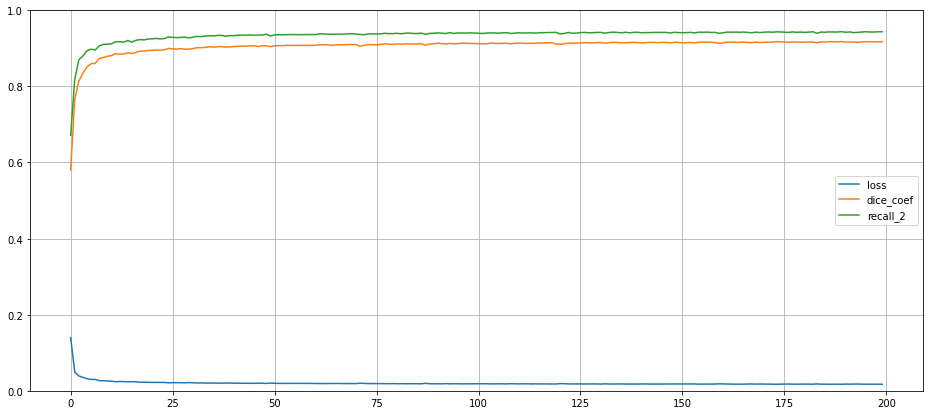

In [ ]:
print(full_modified_wnet_model.evaluate(x_test,y_test))
pd.DataFrame(model_history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.show()